# commands for gdrive

In [2]:
!pip3 install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1nDlBKahqlM_0SgQQwBIgobR-JAwZ9deA'})
download.GetContentFile('german_signs.zip')

In [6]:
!unzip "german_signs"

Archive:  german_signs.zip
   creating: data/
   creating: data/test_images/
  inflating: data/test_images/06578.ppm  
  inflating: data/test_images/11004.ppm  
  inflating: data/test_images/01217.ppm  
  inflating: data/test_images/00109.ppm  
  inflating: data/test_images/09893.ppm  
  inflating: data/test_images/07666.ppm  
  inflating: data/test_images/08555.ppm  
  inflating: data/test_images/03400.ppm  
  inflating: data/test_images/05071.ppm  
  inflating: data/test_images/05717.ppm  
  inflating: data/test_images/02078.ppm  
  inflating: data/test_images/03366.ppm  
  inflating: data/test_images/04409.ppm  
  inflating: data/test_images/07100.ppm  
  inflating: data/test_images/08233.ppm  
  inflating: data/test_images/01571.ppm  
  inflating: data/test_images/11762.ppm  
  inflating: data/test_images/07114.ppm  
  inflating: data/test_images/10468.ppm  
  inflating: data/test_images/08227.ppm  
  inflating: data/test_images/01565.ppm  
  inflating: data/test_images/09139.ppm  

In [2]:
!ls

adc.json  gdrive	    __MACOSX	      model1_loss_1.pth
data	  german_signs.zip  model1_acc_1.pth  sample_data


In [8]:
!pip3 install natsort
!pip3 install imutils
# !pip3 install --upgrade keras

In [8]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Start

## data.py

In [0]:
from __future__ import print_function
import zipfile
import os
import cv2
import torchvision.transforms as transforms
import numpy as np
from skimage import exposure
import torch
import PIL

class CLAHE:
 def __init__(self, clipLimit=0.01, tileGridSize=(4, 4)):
  self.clipLimit = clipLimit
  self.tileGridSize = tileGridSize

 def __call__(self, im):
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
  #clahe = cv2.createCLAHE(clipLimit=self.clipLimit,
  #tileGridSize=self.tileGridSize)
  #im = clahe.apply(img_y)
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
  t = type(im)
  img_y = exposure.equalize_adapthist(np.array(im))
  #im = cv2.merge((img_y,cr,cb)) 
  return np.float32(img_y)#np.transpose(im,[2,0,1])

# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 32 x 32 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set
data_transforms = transforms.Compose([
    transforms.Resize((48,48)),
    #transforms.ToPILImage(),
    #transforms.RandomApply([
    #transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)]),
    #CLAHE(),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])


def initialize_data(folder):
    train_zip = folder + '/train_images.zip'
    test_zip = folder + '/test_images.zip'
    if not os.path.exists(train_zip) or not os.path.exists(test_zip):
        raise(RuntimeError("Could not find " + train_zip + " and " + test_zip
              + ', please download them from https://www.kaggle.com/c/nyu-cv-fall-2018/data '))
    # extract train_data.zip to train_data
    train_folder = folder + '/train_images'
    if not os.path.isdir(train_folder):
        print(train_folder + ' not found, extracting ' + train_zip)
        zip_ref = zipfile.ZipFile(train_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()
    # extract test_data.zip to test_data
    test_folder = folder + '/test_images'
    if not os.path.isdir(test_folder):
        print(test_folder + ' not found, extracting ' + test_zip)
        zip_ref = zipfile.ZipFile(test_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()

    # make validation_data by using images 00000*, 00001* and 00002* in each class
    train_folder = folder + '/augeq_train_images'
    val_folder = folder + '/augeq_val_images'
    if not os.path.isdir(val_folder):
        print(val_folder + ' not found, making a validation set')
        os.mkdir(val_folder)
        for dirs in os.listdir(train_folder):
            files = os.listdir(train_folder + '/' + dirs)
            random_files = np.random.choice(files,int(0.2*len(files)),replace=False)
            if not os.path.isdir(val_folder + '/' + dirs):
                os.mkdir(val_folder + '/' + dirs)
            
            #if dirs.startswith('000'):
             #   os.mkdir(val_folder + '/' + dirs)
            for f in random_files:
                print(train_folder + '/' + dirs + '/' + f,val_folder + '/' + dirs + '/' + f)  
              #if f.startswith('00000') or f.startswith('00001') or f.startswith('00002'):
                        # move file to validation folder
                os.rename(train_folder + '/' + dirs + '/' + f, val_folder + '/' + dirs + '/' + f)


## model.py

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB as 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,padding=(3,3))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5,padding=(2,2))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3,padding=(1,1))
#         self.conv4 = nn.Conv2d(256, 256, kernel_size=3,padding=(1,1))
#         self.conv5 = nn.Conv2d(256, 256, kernel_size=3,padding=(1,1))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(256*6*6, 256)
        self.fc2 = nn.Linear(256, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.batchnorm1(self.conv1(x))), 2)

        x = F.max_pool2d(F.relu(self.batchnorm2(self.conv2(x))), 2)

        x = F.max_pool2d(F.relu(self.batchnorm3(self.conv3(x))), 2)

        x = x.view(-1, 256*6*6)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


# Focal Loss

In [0]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)                         # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))    # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

# Main.py

In [5]:
from __future__ import print_function
import argparse
import torch
#import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
# torch.backends.cudnn.benchmark = True

from torch.autograd import Variable
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import numpy as np
from skimage import exposure
import warnings
# from focalloss import *
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

torch.cuda.empty_cache()
# Training settings
parser = argparse.ArgumentParser(description='PyTorch GTSRB example')
parser.add_argument('--data', type=str, default='data', metavar='D',
                    help="folder where data is located. train_data.zip and test_data.zip need to be found in the folder")
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--epochs', type=int, default=25, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.002, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
# args = parser.parse_args()

torch.manual_seed(1)

########## class weights
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight
#########Gamma for focal loss:
g = 1

#from sklearn.utils import class_weights
### Data Initialization and Loading
# from data import initialize_data, data_transforms # data.py in the same folder
# initialize_data(args.data) # extracts the zip files, makes a validation set

dataset_train = datasets.ImageFolder("./data/" + 'train_images', transform=data_transforms)
#dataset_labels = [i[1] for i in dataset_train.imgs]
#class_count = np.bincount(dataset_labels)
#weights = 1 / np.array([class_count[y] for y in dataset_labels])
#weights = make_weights_for_balanced_classes(dataset_train.imgs, 43)
#weights = torch.DoubleTensor(weights)       
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
#print(weights)
#datasets.ImageFolder(args.data + '/train_images', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(
#    datasets.ImageFolder(args.data + '/train_images',
 #                        transform=data_transforms),
    dataset_train,
    batch_size=64, shuffle=True, num_workers=12)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./data' + '/val_images',
                         transform=data_transforms),
    batch_size=64, shuffle=False, num_workers=12)


### Neural Network and Optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
# from model import Net
model = Net()
#model = torchvision.models.resnet18(pretrained=False, progress=True)
#model = torchvision.models.vgg16_bn(pretrained=False, progress=True)
model.cuda()
summary(model, (3, 48, 48))
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        correct = 0
        data, target = Variable(data), Variable(target)
        #print(data.shape,target.shape)
        #print(np.bincount(target))
        #for i in range(data.shape[0]):
           # print(data[i].shape)#,np.max(data[i]),np.min(data[i]))
        #   with warnings.catch_warnings():
         #      warnings.simplefilter("ignore")
            #y,cb,cr = cv2.split(cv2.cvtColor(data[i], cv2.COLOR_BGR2YCR_CB))
            #clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4,4))
            #y = clahe.apply(y)
            #data[i] = cv2.merge((y,cb,cr))#exposure.equalize_adapthist(data[i])
          #  data[i] = exposure.equalize_adapthist(data[i])    
       #print_progress(i + 1, X.shape[0])
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)#FocalLoss(gamma=g)(output,target)#F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]# get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        running_loss += loss.item() * data.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), (100. * correct / 64)))
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss
    #    torch.cuda.empty_cache()

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    y_pred = []
    y_true = []
    for data, target in val_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        #y_true.append(torch.argmax(target,-1))
        #for i in range(data.shape[0]):
            #y,cb,cr = cv2.split(cv2.cvtColor(data[i], cv2.COLOR_BGR2YCR_CB))
            #clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4,4))
            #y = clahe.apply(y)
            #data[i] = cv2.merge((y,cb,cr))
           #with warnings.catch_warnings():
           #    warnings.simplefilter("ignore")
         #   data[i] = exposure.equalize_adapthist(data[i])
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        #op = model(data)
        #y_pred.append(torch.argmax(output,-1))
        validation_loss += F.nll_loss(output, target, size_average=False).item()#.cpu()#FocalLoss(gamma = g)(output,target)#F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]#.cpu() # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()
    #print(100. * correct / len(val_loader.dataset))
    acc = 100. * correct / len(val_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        acc))
    if epoch == 100:
        print(epoch)
    return acc,validation_loss
        #print(confusion_matrix(y_true,y_pred))        

val_loss = 200
val_acc = 0
lossp = []
valp = []
for epoch in range(1, 200 + 1):
    epoch_loss = train(epoch)
    lossp.append(epoch_loss)
    va,vl = validation()
    valp.append(va.item())
    scheduler.step(va)
    print(va,vl)
    if va > val_acc:
        val_acc = va
        model_file = 'model1_acc_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), model_file)
        print('\nSaved Best acc model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')  
        
    if vl < val_loss:
        val_loss = vl
        model_file = 'model1_loss_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), model_file)
        print('\nSaved Best loss model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,472
       BatchNorm2d-2           [-1, 64, 48, 48]             128
            Conv2d-3          [-1, 128, 24, 24]         204,928
       BatchNorm2d-4          [-1, 128, 24, 24]             256
            Conv2d-5          [-1, 256, 12, 12]         295,168
       BatchNorm2d-6          [-1, 256, 12, 12]             512
            Linear-7                  [-1, 256]       2,359,552
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                   [-1, 43]          11,051
Total params: 2,881,579
Trainable params: 2,881,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 3.94
Params size (MB): 10.99
Estimated Total Size (MB): 14.96
-------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.850832 	Accuracy 1.5625
Train Epoch: 1 [6400/35339 (18%)]	Loss: 1.332861 	Accuracy 64.0625
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.507125 	Accuracy 89.0625
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.227041 	Accuracy 96.8750
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.221881 	Accuracy 95.3125
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.163546 	Accuracy 98.4375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Average loss: 0.3221, Accuracy: 3516/3870 (91%)

tensor(90.8527) 0.32208002839593614

Saved Best acc model to model1_acc_1.pth. You can run `python evaluate.py --model model1_acc_1.pth` to generate the Kaggle formatted csv file


Saved Best loss model to model1_loss_1.pth. You can run `python evaluate.py --model model1_loss_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/35339 (0%)]	Loss: 0.082953 	Accuracy 98.4375
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.050781 	Accuracy 100.0000
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.082070 	Accuracy 96.8750
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.061588 	Accuracy 96.8750
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.064429 	Accuracy 98.4375
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.043239 	Accuracy 98.4375

Validation set: Average loss: 0.2235, Accuracy: 3664/3870 (95%)

tensor(94.6770) 0.22350067436233048

Saved Best acc model to model1_acc_2.pth. You can run `python evaluate.py --model model1_acc_2.pth` t

KeyboardInterrupt: ignored

# Plots

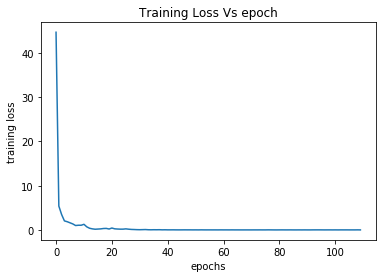

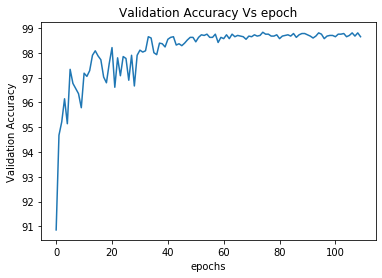

In [6]:
import matplotlib.pyplot as plt
plt.plot(lossp)
plt.title('Training Loss Vs epoch')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.show()
plt.plot(valp)
plt.title('Validation Accuracy Vs epoch')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy')
plt.show()

## evaluate.py

In [12]:
from __future__ import print_function
import argparse
from tqdm import tqdm
import os
import PIL.Image as Image
import numpy as np
from skimage import exposure
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
# from data import initialize_data # data.py in the same folder
# from model import Net
import PIL
import cv2

parser = argparse.ArgumentParser(description='PyTorch GTSRB evaluation script')
parser.add_argument('--data', type=str, default='data', metavar='D',
                    help="folder where data is located. train_data.zip and test_data.zip need to be found in the folder")
parser.add_argument('--model', type=str, metavar='M',
                    help="the model file to be evaluated. Usually it is of the form model_X.pth")
parser.add_argument('--outfile', type=str, default='gtsrb_kaggle.csv', metavar='D',
                    help="name of the output csv file")

# args = parser.parse_args()

state_dict = torch.load("./model1_acc_75.pth")
model = Net()
model.load_state_dict(state_dict)
model.eval()

# from data import data_transforms

class CLAHE:
    def __init__(self, clipLimit=0.01, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
  #clahe = cv2.createCLAHE(clipLimit=self.clipLimit,
  #tileGridSize=self.tileGridSize)
  #im = clahe.apply(img_y)
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
        t = type(im)
        img_y = exposure.equalize_adapthist(np.array(im))
     #   print(img_y.shape)
        b,g,r = cv2.split(img_y)
        img_y = cv2.merge((r,g,b))
  #im = cv2.merge((img_y,cr,cb)) 
        return np.float32(img_y)#np.transpose(im,[2,0,1])

data_transforms = transforms.Compose([
    #CLAHE(),
    transforms.Resize((48,48)),
    #transforms.ToPILImage(),
   # data_transforms = transforms.Compose([
    #transforms.Resize((48, 48)),
    #transforms.ToPILImage(),
    #transforms.RandomApply([
    #transforms.RandomRotation(degrees = 20, resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(degrees = 0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(degrees = 0, shear=20, resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(degrees = 0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)]),
    #CLAHE(),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

test_dir = "./data" + '/test_images'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


output_file = open("gtsrb_kaggle.csv", "w")
output_file.write("Filename,ClassId\n")
for f in tqdm(os.listdir(test_dir)):
    if 'ppm' in f:
        data = data_transforms(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = Variable(data, volatile=True)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]

        file_id = f[0:5]
        output_file.write("%s,%d\n" % (file_id, pred))

output_file.close()

print("Succesfully wrote " + 'gtsrb_kaggle.csv' + ', you can upload this file to the kaggle '
      'competition at https://www.kaggle.com/c/nyu-cv-fall-2018/')
        




  0%|          | 0/12631 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 12631/12631 [02:05<00:00, 101.57it/s]

Succesfully wrote gtsrb_kaggle.csv, you can upload this file to the kaggle competition at https://www.kaggle.com/c/nyu-cv-fall-2018/


In [0]:
!cp "./gtsrb_kaggle.csv" "/content/gdrive/My Drive/german_signs/"

## Augment.py

In [0]:
import torch
from torchvision import datasets, transforms
import PIL
from skimage import exposure
import numpy as np
import cv2
import os
#import matplotlib.pyplot as plt

class CLAHE:
    def __init__(self, clipLimit=0.01, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
  #clahe = cv2.createCLAHE(clipLimit=self.clipLimit,
  #tileGridSize=self.tileGridSize)
  #im = clahe.apply(img_y)
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
        t = type(im)
        img_y = exposure.equalize_adapthist(np.array(im))
  #im = cv2.merge((img_y,cr,cb)) 
        return np.float32(img_y)#np.transpose(im,[2,0,1])

data_transforms = transforms.Compose([
    #CLAHE(),
    transforms.Resize((48, 48)),
    #transforms.ToPILImage(),
   # data_transforms = transforms.Compose([
    #transforms.Resize((48, 48)),
    #transforms.ToPILImage()
    transforms.RandomApply([
    transforms.RandomRotation(degrees = 20),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees = 0, shear=20),
    transforms.RandomAffine(degrees = 0, scale=(0.8, 0.8))]),
    transforms.ToTensor(),
#    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])
data_transforms1 = transforms.Compose([
    #CLAHE(),
    transforms.Resize((48, 48)),
   # transforms.ToPILImage(),
    #transforms.RandomApply([
    #transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
    #transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
   # transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)]),
  #  CLAHE(),
    transforms.ToTensor(),
 #   transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

def make_weights_for_balanced_classes(images, nclasses):
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight

dataset_train = datasets.ImageFolder("./data" + '/train_images', transform=data_transforms)
dataset_train_orig = datasets.ImageFolder("./data" + '/train_images', transform=data_transforms1)
#dataset_train1 = torch.utils.data.ConcatDataset((dataset_train_aug,dataset_train_orig))
#class CLAHE:
    #def __init__(self, clipLimit=0.01, tileGridSize=(4, 4)):
     #   self.clipLimit = clipLimit
      #  self.tileGridSize = tileGridSize

    #def __call__(self, im):
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
  #clahe = cv2.createCLAHE(clipLimit=self.clipLimit,
  #tileGridSize=self.tileGridSize)
  #im = clahe.apply(img_y)
  #img_y,cr,cb = cv2.split(cv2.cvtColor(np.transpose(np.float32(im),[1,2,0]), cv2.COLOR_RGB2YCrCb))
       # t = type(im)
       # img_y = exposure.equalize_adapthist(np.array(im))
#dataset_labels = [i[1] for i in dataset_train.imgs]
#class_count = np.bincount(dataset_labels)
#weights = 1 / np.array([class_count[y] for y in dataset_labels])
weights = make_weights_for_balanced_classes(dataset_train.imgs, 43)
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 43*3000)

train_loader = torch.utils.data.DataLoader(
#    datasets.ImageFolder(args.data + '/train_images',
 #                        transform=data_transforms),
    torch.utils.data.ConcatDataset((dataset_train_orig,dataset_train)),
    batch_size=64, sampler = sampler, num_workers=4)

for i,(image,label) in enumerate(train_loader):
    image = image.data.numpy()
    print(i)
    label = label.data.numpy()
    for j in range(image.shape[0]):
        if not os.path.isdir("./data/augeq_train_images/" + str(label[j]) + "/"):
            os.mkdir("./data/augeq_train_images/" + str(label[j]) + "/")
        image1 = np.transpose(image[j],[1,2,0])
#         print(np.unique(image))
#         plt.imshow(image1)
#         plt.show()
        cv2.imwrite("./data/augeq_train_images/"+ str(label[j]) + "/"+str(i+j)+".ppm",image1*255)
                                                                                                     

# Report


In [0]:


1) Tried a basic model consisting of 3 convolutional layers all with 3x3 filters and two dense layers including the output. 
2) Referenced and experimented with 7x7 and 5x5 filters which worked better. Finally 7x7 for the first layer , 5x5 for the second and 3x3 for the third convolutional layer respectively work best.
3) Included batch normalization after each layer. Gave better val accuracy
4) Flatten vs Global Average Pooling. Gave better val accuracy with flattening the final vector
5) Tried to use Focal loss with various gamma values to handle classifying hard classes (in this case classes having low number of images). Gamma = 1 worked best.
6) Experimented with the number of neurons in the last before dense layer. 256 neurons worked best.
7) Dropouts after conv layers did not work well (does not make sense but many papers use this). However dropouts after dense layers seem to increase the accuracy.
8) Tried to train on the given dataset and then finetune on a manually created balanced set containing equal number of images (Least number of images in all classes will be the number of images per class). It did not improve accuracy.
9) Added a learning rate scheduler which would reduce the learning rate when validation accuracy flattens out.
10) Saved the models only if val accuracy or loss increases or decreases respectively.
11) Experimented with various input sizes (48 and 32) 48 gave the best accuracy.
12) Created an augmented dataset consisting of 1200 images per class using randomly applying rotation, shearing, translation or scaling to the image. Used a balanced random sampler to achieve this using class weights.
12a) Used Contrast limited adaptive histogram equalization for reducing illumination variation over the images.
12b) Trained on the augmented dataset using the same network and achieved 99% accuracy on the val set. However, due to some errors while transforming, the test set accuracy was below 0.01 which was fishy and needs debugging. 

# References

In [0]:
1) J. Stallkamp, M. Schlipsing, J. Salmen, C. Igel,
   Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition, Neural Networks, Volume 32, 2012, Pages 323-332, ISSN 0893-6080,
   https://doi.org/10.1016/j.neunet.2012.02.016. (http://www.sciencedirect.com/science/article/pii/S0893608012000457)
2) P. Sermanet and Y. LeCun, "Traffic sign recognition with multi-scale Convolutional Networks," The 2011 International Joint Conference on Neural Networks, San Jose, CA, 2011, pp. 2809-2813.
   doi: 10.1109/IJCNN.2011.6033589
   keywords: {computer vision;image classification;image colour analysis;traffic engineering computing;traffic sign recognition;multiscale convolutional network;traffic sign classification;GTSRB competition;multistage architecture;hierarchy learning;vision approach;hand-crafted features;HOG;SIFT;greyscale images;Image color analysis;Accuracy;Training;Color;Feature extraction;Neural networks;Computer architecture},
   URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6033589&isnumber=6033131
3) \bibitem[Lin et al.(2017)]{2017arXiv170802002L} Lin, T.-Y., Goyal, P., Girshick, R., et al.\ 2017, arXiv e-prints, arXiv:1708.02002
